In [1]:
import time
# get_ipython().run_line_magic('matplotlib', 'inline')
# import matplotlib.pyplot as plt
# get_ipython().run_line_magic('matplotlib', 'inline')
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('white')
import statsmodels.api as sm
from sklearn import preprocessing 
import ema_workbench.em_framework.evaluators
import matplotlib.pyplot as plt

In [2]:
import os
from dest_directories import gz_path, fig_path
from dicemodel.noDICE_v7 import PyDICE
model_version = 'v7'

from dicemodel.specs import nordhaus_policy, reference_scenario, change_fontsize

In [3]:
from ema_workbench import (perform_experiments, Model, Policy, Scenario, ReplicatorModel, RealParameter, IntegerParameter, TimeSeriesOutcome, ScalarOutcome, ArrayOutcome, Constant, ema_logging, SequentialEvaluator, MultiprocessingEvaluator, IpyparallelEvaluator)
from ema_workbench import save_results, load_results
from ema_workbench.analysis import prim, cart
from ema_workbench.analysis import scenario_discovery_util as sdutil
from ema_workbench.analysis import plotting, plotting_util, pairs_plotting, parcoords

ema_logging.log_to_stderr(ema_logging.INFO)

model = PyDICE()
dice_sm = Model('dicesmEMA', function=model)

In [4]:


dice_sm.uncertainties = [
                             RealParameter('tfp_gr',  0.07, 0.09),
                             RealParameter('sigma_gr', -0.012, -0.008),
                             RealParameter('pop_gr', 0.1, 0.15),
                             RealParameter('fosslim',  4000.0, 13649),
                             IntegerParameter('cback', 100, 600),
                             RealParameter('emdd', -1, 0.99),
                             IntegerParameter('vd_switch', 0, 1),
                            ]
    
dice_sm.levers = [RealParameter('sr', 0.1, 0.5),
                      RealParameter('prtp_con',  0.001, 0.015),
                      RealParameter('emuc', 1.01, 2.00),
                      # IntegerParameter('vd_switch', 0, 1),
                      IntegerParameter('periodfullpart', 10, 58),
                      IntegerParameter('miu_period', 10, 58)
                      ]

dice_sm.outcomes = [
                        TimeSeriesOutcome('Atmospheric Temperature'),
                        TimeSeriesOutcome('Total Output'),
                        TimeSeriesOutcome('Per Capita Consumption'),
                        TimeSeriesOutcome('Consumption Growth'),
                        TimeSeriesOutcome('Utility of Consumption'),
                        TimeSeriesOutcome('Per Capita Damage'),
                        TimeSeriesOutcome('Damage Growth'),
                        TimeSeriesOutcome('Disutility of Damage'),
                        TimeSeriesOutcome('Welfare'),
                        # TimeSeriesOutcome('Undiscounted Period Welfare'),
                        TimeSeriesOutcome('Consumption SDR'),
                        TimeSeriesOutcome('Damage SDR'),
                        TimeSeriesOutcome('SCC')
                    ]
# dice_sm.outcomes = [
#             ScalarOutcome('Atmospheric Temperature 2300', kind=ScalarOutcome.MINIMIZE),
#             ScalarOutcome('Total Output 2300', kind=ScalarOutcome.MAXIMIZE),
#             # ScalarOutcome('Per Capita Consumption 2300', kind=ScalarOutcome.INFO),
#             # ScalarOutcome('Consumption Growth 2300', kind=ScalarOutcome.INFO),
#             ScalarOutcome('Utility of Consumption 2300', kind=ScalarOutcome.MAXIMIZE),
#             # ScalarOutcome('Per Capita Damage 2300', kind=ScalarOutcome.INFO),
#             # ScalarOutcome('Damage Growth 2300', kind=ScalarOutcome.INFO),
#             ScalarOutcome('Disutility of Damage 2300', kind=ScalarOutcome.MINIMIZE),
#             ScalarOutcome('Welfare 2300', kind=ScalarOutcome.MAXIMIZE),
#             # ScalarOutcome('Undiscounted Period Welfare 2300', kind=ScalarOutcome.INFO),
#             ScalarOutcome('Consumption SDR 2300', kind=ScalarOutcome.INFO),
#             ScalarOutcome('Damage SDR 2300', kind=ScalarOutcome.INFO)
            # ]


In [5]:
dice_opt = pd.read_excel("DICE2013R.xlsm" ,sheet_name = "Opttax", index_col = 0)


In [19]:
nord_optimal_policy = Policy('nord_optimal_policy', **nordhaus_policy(np.mean(dice_opt.iloc[129]),prtp_con =0.015,emuc=1.45, miu_period= 29, periodfullpart=29 )) # ,vd_switch=1  
nord_optimal_policy

Policy({'sr': 0.24868248835166676, 'prtp con': 0.015, 'emuc': 1.45, 'periodfullpart': 29, 'miu_period': 0})

In [7]:
n_scenarios = 100000
run = 'run_34_NordOE_'

# 32: OE with corrected emdd range
# 33: vd_switch back in the uncertainties. We will have both outcomes for comparison with Nordhaus policy ----- very weird results. No effect of vd switch at all. showing much higher values for SCC, much lower for temp, V(D) either 0 or 1??
# 34: retry
# 35?: miu_period corrected to 29, from 0.

In [ ]:
# from ema_workbench.em_framework.evaluators import BaseEvaluator

# with MultiprocessingEvaluator(dice_sm) as evaluator:
#     results1 = evaluator.optimize(nfe=5e3, searchover='levers', epsilons=[0.1,]*len(dice_sm.outcomes))

In [8]:
# Nordhaus Open exploration
start = time.time()
with MultiprocessingEvaluator(dice_sm) as evaluator:
    results = evaluator.perform_experiments(scenarios=n_scenarios, policies=nord_optimal_policy)
end = time.time()

print('Experiment time is ' + str(round((end - start)/60)) + ' mintues')

[MainProcess/INFO] pool started
[MainProcess/INFO] performing 100000 scenarios * 1 policies * 1 model(s) = 100000 experiments
[MainProcess/INFO] 10000 cases completed
[MainProcess/INFO] 20000 cases completed
[MainProcess/INFO] 30000 cases completed
[MainProcess/INFO] 40000 cases completed
[MainProcess/INFO] 50000 cases completed
[MainProcess/INFO] 60000 cases completed
[MainProcess/INFO] 70000 cases completed
[MainProcess/INFO] 80000 cases completed
[MainProcess/INFO] 90000 cases completed
[MainProcess/INFO] 100000 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool
Experiment time is 2 mintues


In [9]:
experiments, outcomes = results

In [10]:
# experiments, outcomes = results

start = time.time()
save_results(results, os.path.join(gz_path, str(run) + str(model_version) + '_' + str(n_scenarios) + 's_' +  '.tar.gz'))
end = time.time()

print('Saving time is ' + str(round((end - start)/60)) + ' mintues')

# run_14_NordOE_v6100000s_.tar.gz is a good one, with vd_switch showing both 0 and 1, unline run 13

[MainProcess/INFO] results saved successfully to E:\Year_2_Quarter_4\Thesis\06_Code\results\gz_files\run_34_NordOE_v7_100000s_.tar.gz
Saving time is 5 mintues


In [8]:
results = load_results(os.path.join(gz_path,'run_33_NordOE_v7_100000s_.tar.gz'))
experiments, outcomes = results

[MainProcess/INFO] results loaded succesfully from E:\Year_2_Quarter_4\Thesis\06_Code\results\gz_files\run_33_NordOE_v7_100000s_.tar.gz


In [9]:
# # experiments['vd_switch']
# experiments.info()
# unique_counts = pd.DataFrame.from_records([(col, experiments[col].nunique()) for col in experiments.columns],
#                           columns=['Column_Name', 'Num_Unique']).sort_values(by=['Num_Unique'])
# unique_counts

In [11]:
cleaned_outcome = {}

In [12]:
for key, value in outcomes.items():
    cleaned_outcome[key] = value[:,2:-5]  
cleaned_outcome['Welfare'].shape

(100000, 58)

In [ ]:
# pairs 1 = output, temp, damages, consumption, U(C)
# pairs 2 = temp, U(C), V(D), W, SCC 
# pairs 3 = Con, con_g, sdr_con, U(C)
# pairs 4 = damages, sdr_dam, V(D) 
# pairs time = temp, U(C), V(D), W, SCC 
# pairs time 2 = con, dam, sdr_con, sdr_dam

In [13]:
cleaned_outcome_pairs_time = outcomes

In [14]:
# remove outcomes that you dont need for pairs plots and time series
rem_list = [
    # 'Atmospheric Temperature',
    'Total Output',
    'Per Capita Consumption',
    'Consumption Growth',
    # 'Utility of Consumption',
    'Per Capita Damage',
    'Damage Growth',
    # 'Disutility of Damage',
    # 'Welfare',
    'Consumption SDR',
    'Damage SDR',
    # 'SCC'
]
for key in rem_list:
    cleaned_outcome_pairs_time.pop(key)
    

In [15]:
cleaned_outcome_pairs_time.keys()

dict_keys(['Atmospheric Temperature', 'Utility of Consumption', 'Disutility of Damage', 'Welfare', 'SCC'])

In [17]:
# Values for 2300
end_outcome = {}
for key, value in cleaned_outcome_pairs_2.items():
    end_outcome[key] = value[:, -1]  
# end_outcome['Welfare']
# np.mean(cleaned_outcome['Damage Growth'], axis =0)


Pairs plotting using sns grouped by emdd values

In [ ]:
# clr_palette = ([sns.cubehelix_palette(8)[6],sns.color_palette("inferno", 15)[-2],sns.color_palette("YlGn", 15)[10]])

In [18]:
out_DF = pd.DataFrame(end_outcome)
out_DF.head()
emdd = experiments['emdd']
out_DF['emdd'] = emdd

In [19]:
out_DF['emdd'] = out_DF['emdd'].apply(
    lambda x: '-1 to -0.5' if x < -0.5
        else('-0.5 to 0' if (x < 0)
            else('0 to 0.5' if (x < 0.5)
                else ('0.5 to 0.99')
                )
            )
    )

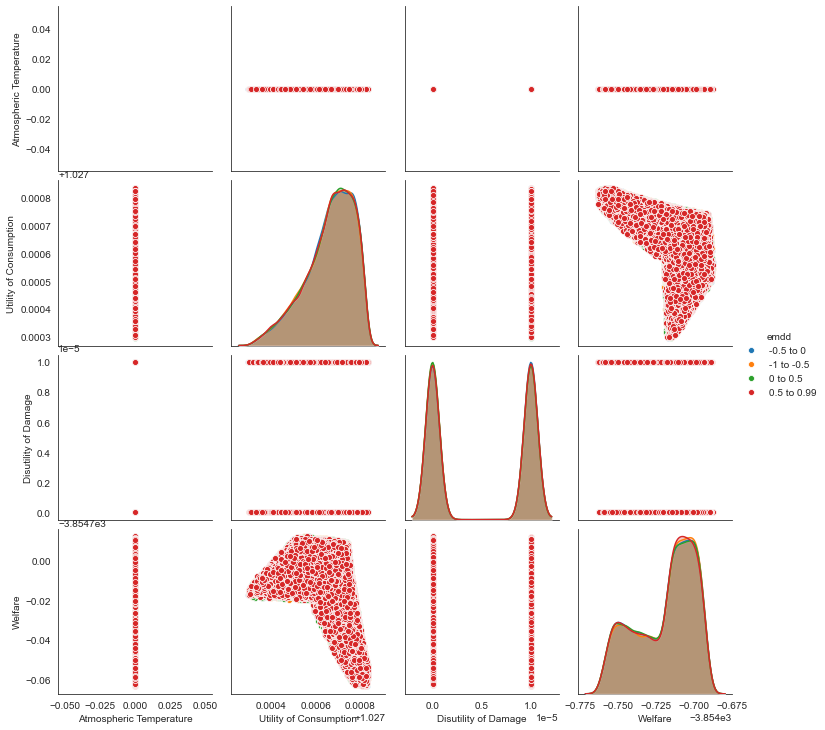

In [20]:

sns_plot = sns.pairplot(out_DF, hue='emdd', vars=list(end_outcome.keys())) # palette=clr_palette
# fig, ax = plt.pyplot.subplots(figsize=)
# fig.set_size_inches(20, 20)
sns_plot.savefig(os.path.join(fig_path, str(run) + '_v7_snspairs_1_by_emdd' +'.png'))
plt.show()

In [ ]:
# Pairs plotting using ema workbench grouped by V(D) switch on/ off

In [20]:
# grouping_specifiers_VD = {'without V(D)':0, 'with V(D)':1}
# grouping_labels_VD = (grouping_specifiers_VD.keys())a

In [18]:
fig, axes = pairs_plotting.pairs_scatter(experiments,outcomes, group_by='vd_switch',grouping_specifiers=grouping_specifiers_VD, legend=True, transparent=True)
fig.set_size_inches(20,20)
plt.show()

repeat_token = 1
fig.savefig(os.path.join(fig_path, str(run) + '_v6_OE_pairs_grouped_V(D)switch_' + str(repeat_token) + '.png'))

In [21]:
scc_per_exp = np.mean(outcomes['SCC'], axis = 1)
scc_per_exp
scc = np.mean(scc_per_exp)
scc

44.47520197197163

In [ ]:

noutcomes = {}
for i in range(int(len(outcomes.keys())/5)):
    arr = np.stack((outcomes[x] for x in list(outcomes.keys())[i::4]), axis=-1)
    key = list(outcomes.keys())[i][:-5]
    noutcomes[key] = arr

outcome_name = []
for i in range(4):
    outcome_name.append(str(dice_sm.outcomes[i])[15:-7])
outcome_name.sort()

print ("time series clustering")
for i in range(4):
    data = noutcomes[outcome_name[i]]

    # calcuate distances
    start = time.time()
    distances = clusterer.calculate_cid(data)
    #np.save('TSC_30k_scen_damages_distances', distances)
    end = time.time()
    print('Calculation time is ' + str(round((end - start)/60)) + ' mintues')

    #calculate silhouette width
    sil_score_lst = []
    start = time.time()
    for n_clusters in range(2,11):
        clusterers = AgglomerativeClustering(n_clusters=n_clusters, affinity='precomputed', linkage="complete")
        cluster_labels = clusterers.fit_predict(distances)
        silhouette_avg = silhouette_score(distances, cluster_labels, metric="precomputed")
        sil_score_lst.append(silhouette_avg)
        print(outcome_name[i] + ": For n_clusters =", n_clusters, "The average silhouette_score is :", silhouette_avg)
    end = time.time()
    print('Clustering time is ' + str(round((end - start)/60)) + ' mintues')

    with open(outcome_name[i] + '_cluster_silhouette_width.txt', 'w') as f:
        for s in sil_score_lst:
            f.write(str(s) + "\n")

    # do agglomerative clustering on the distances
    start = time.time()
    for j in range(2, 6):
        clusters = clusterer.apply_agglomerative_clustering(distances,
                                                            n_clusters=j)
        x = experiments.copy()
        x['clusters'] = clusters.astype('object')
        x.to_csv('TSC_30k_' + outcome_name[i] + '_cluster_' + str(j) + '.csv')
    end = time.time()
    print('Clustering time is ' + str(round((end - start) / 60)) + ' mintues')


In [17]:
grouping_specifiers_VD = {'without V(D)':0, 'with V(D)':1}
grouping_labels_VD = (grouping_specifiers_VD.keys())

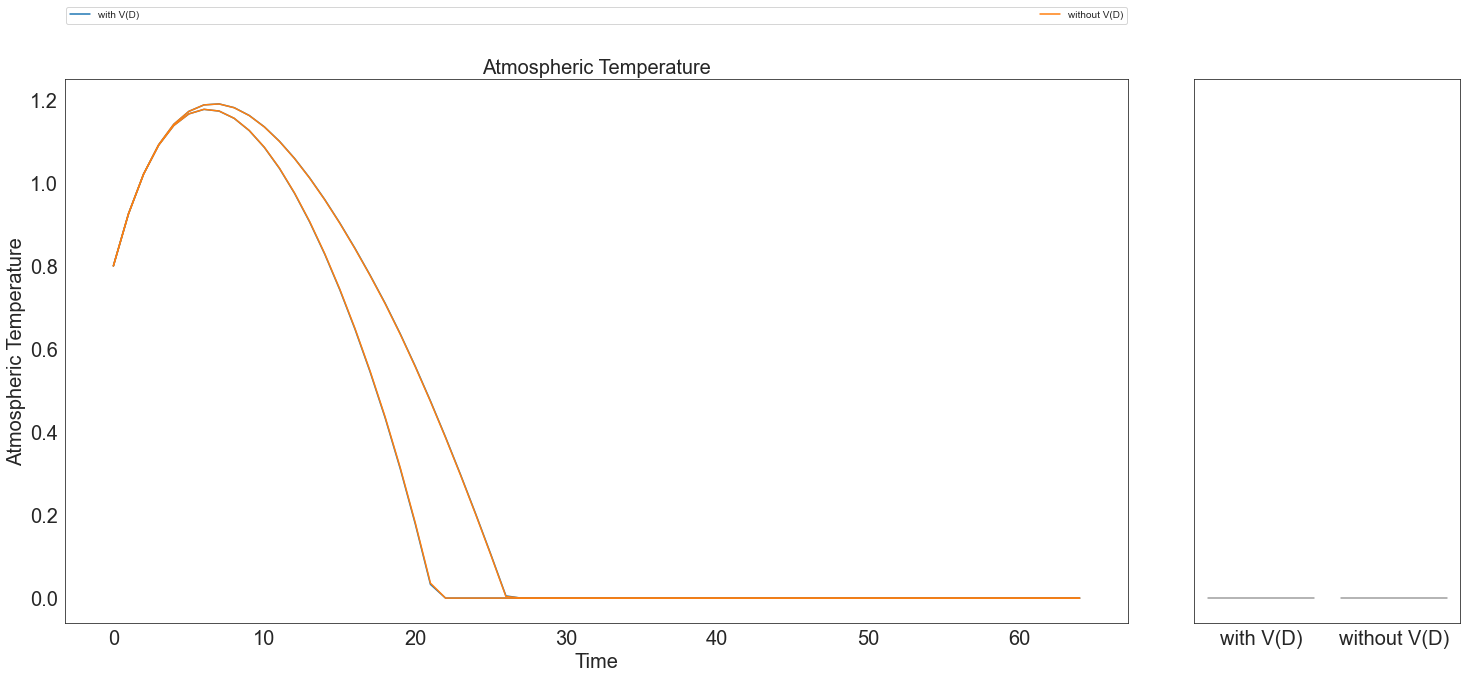

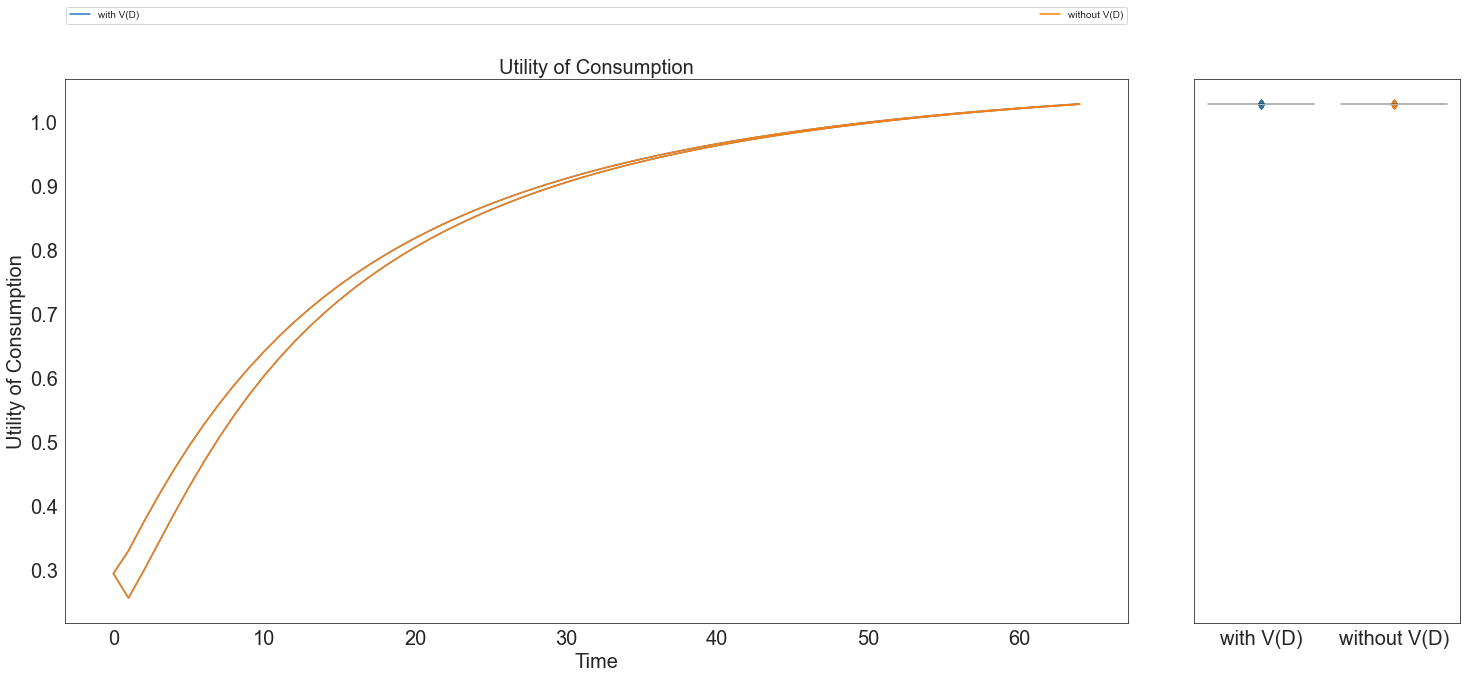

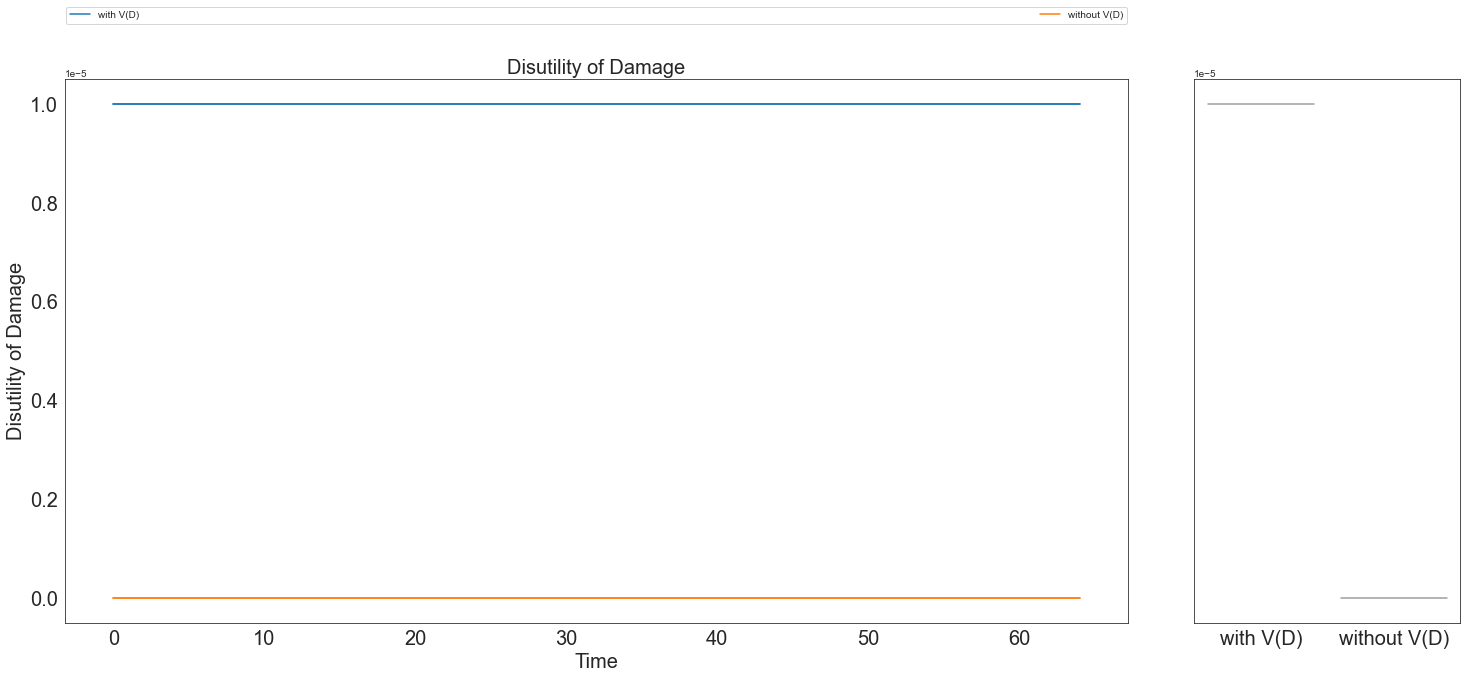

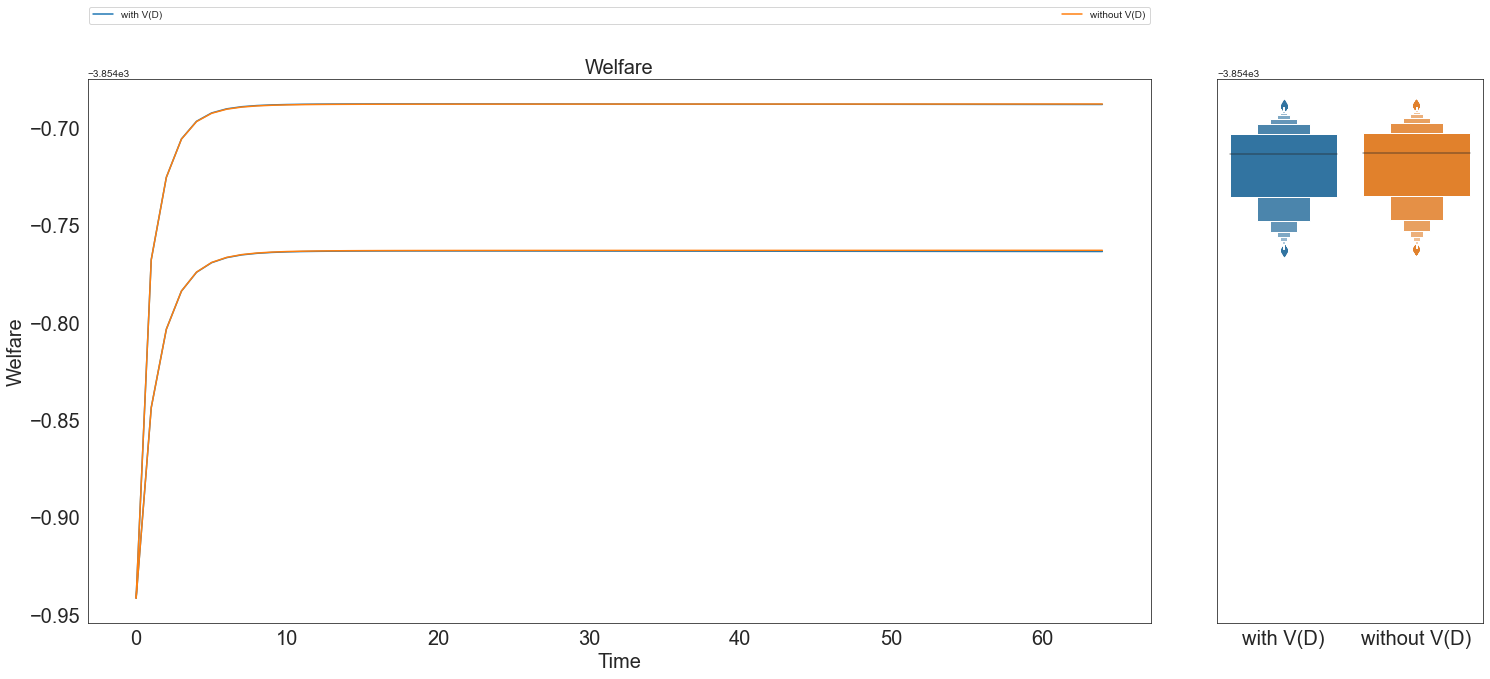

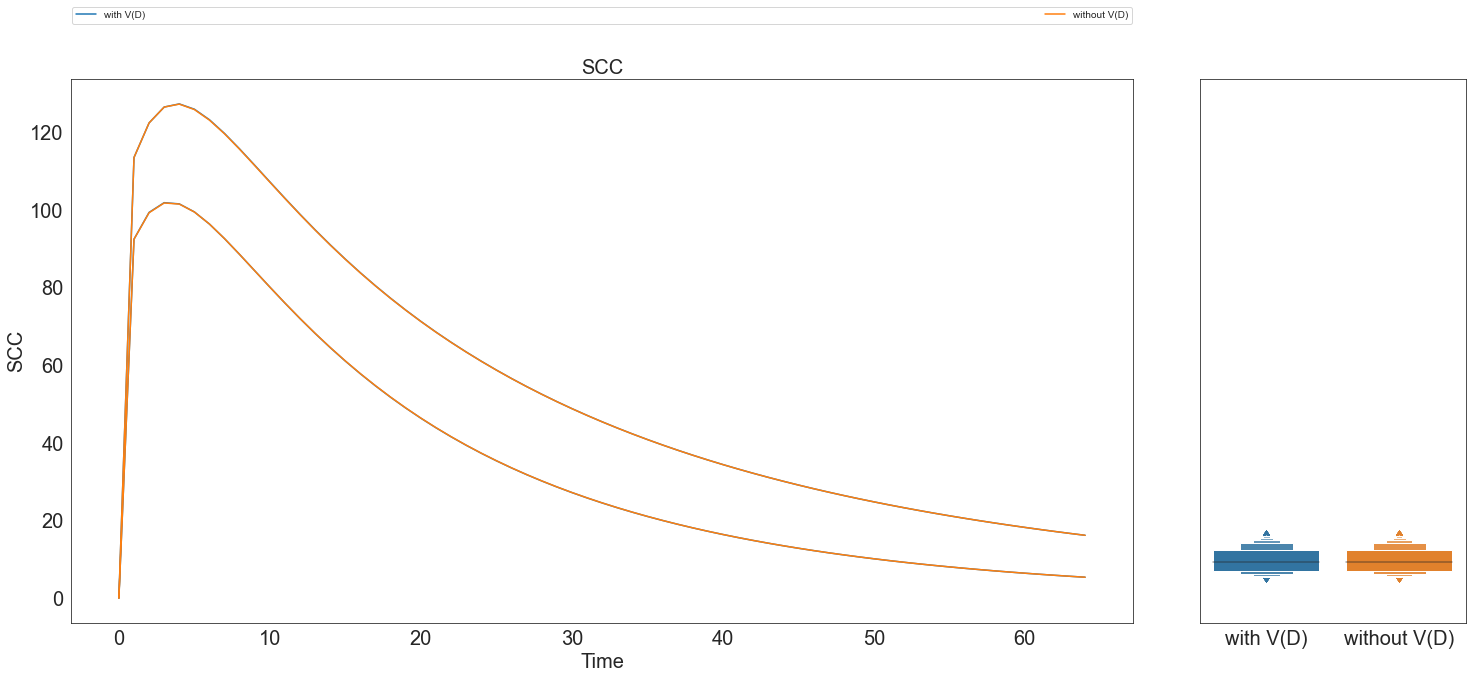

In [18]:
# Time series envelope outcome grouped by V(D) switch

for outcome in cleaned_outcome_pairs_time.keys():
    fig,axes=plotting.envelopes(experiments, cleaned_outcome_pairs_time, outcomes_to_show=outcome, density=plotting.Density.BOXENPLOT, group_by='vd_switch', grouping_specifiers= grouping_specifiers_VD,legend=True)
    

    fig.set_size_inches(25, 10)
    change_fontsize(fig, fs=20)
    repeat_token = 2
    fig.savefig(os.path.join(fig_path, str(run) +'_Time_grouped_envelope_' + str(outcome) + '_repeat' +str(repeat_token) + '.png'))
plt.show()


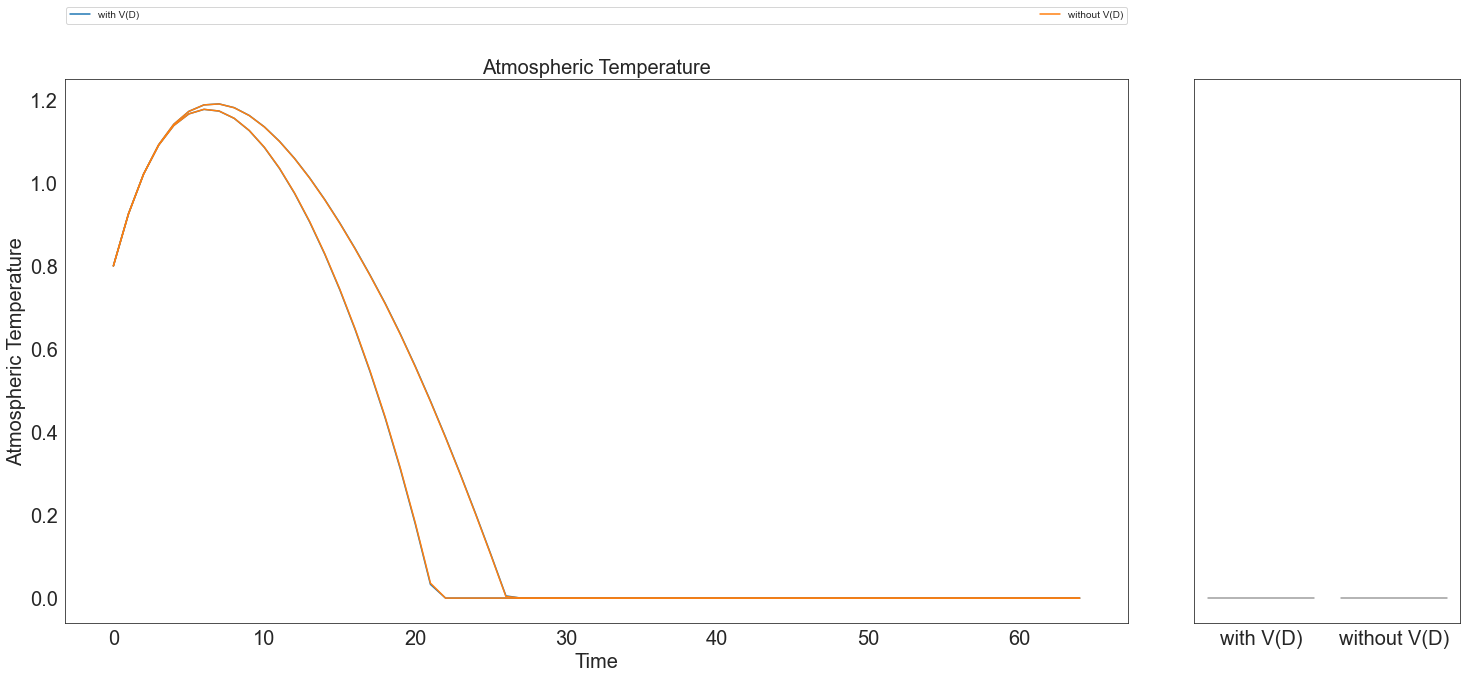

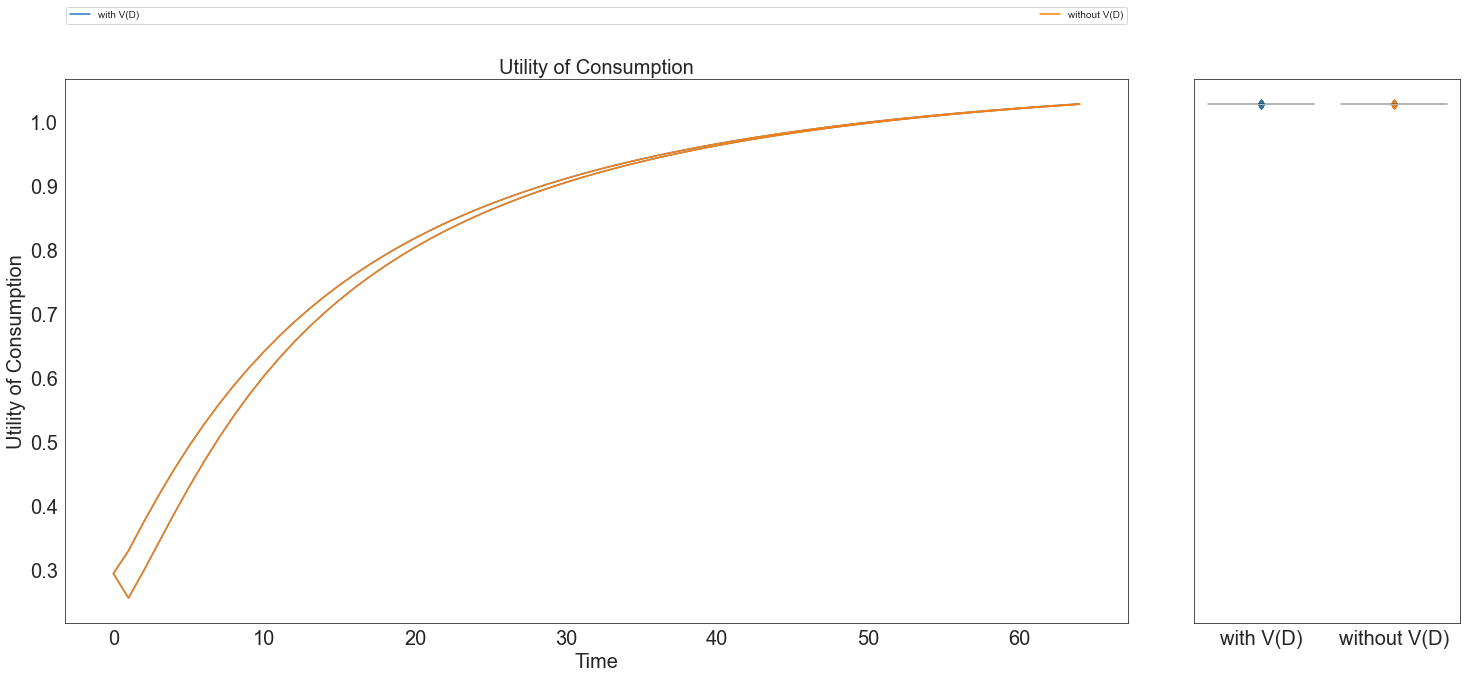

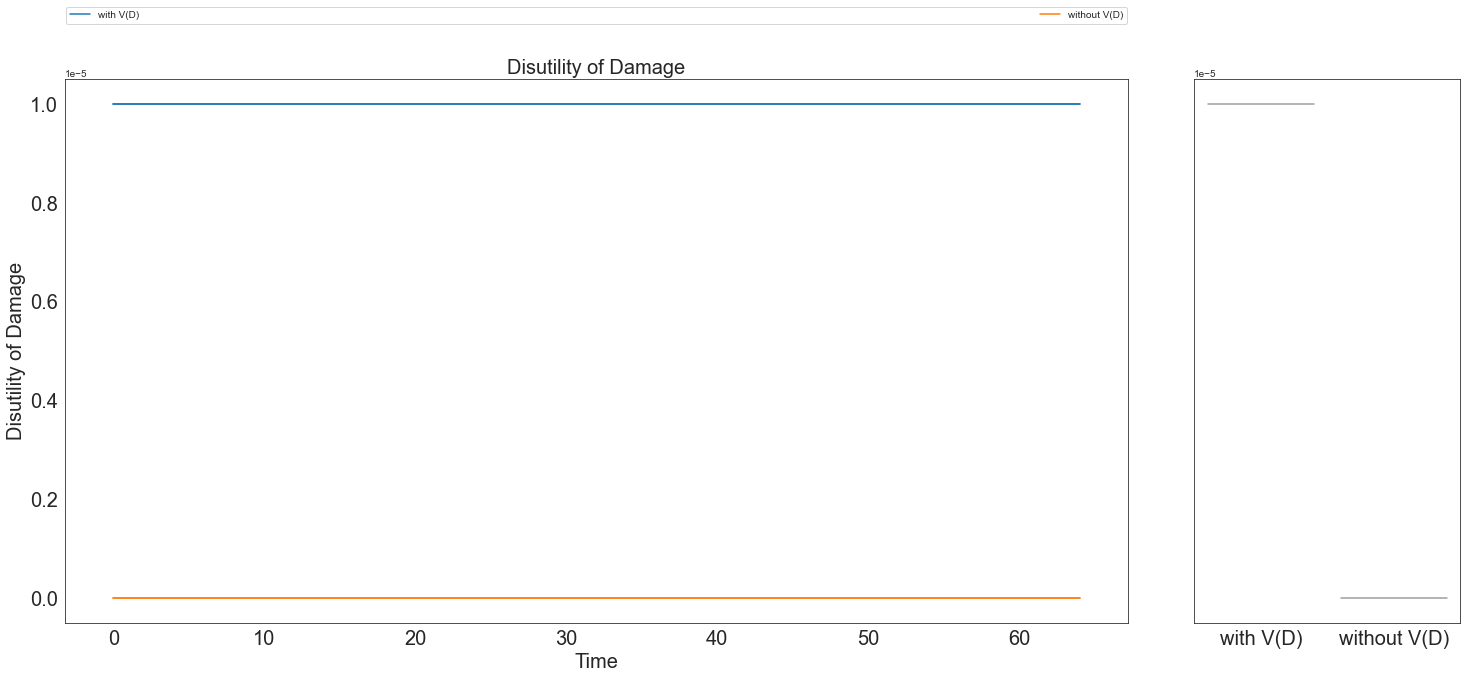

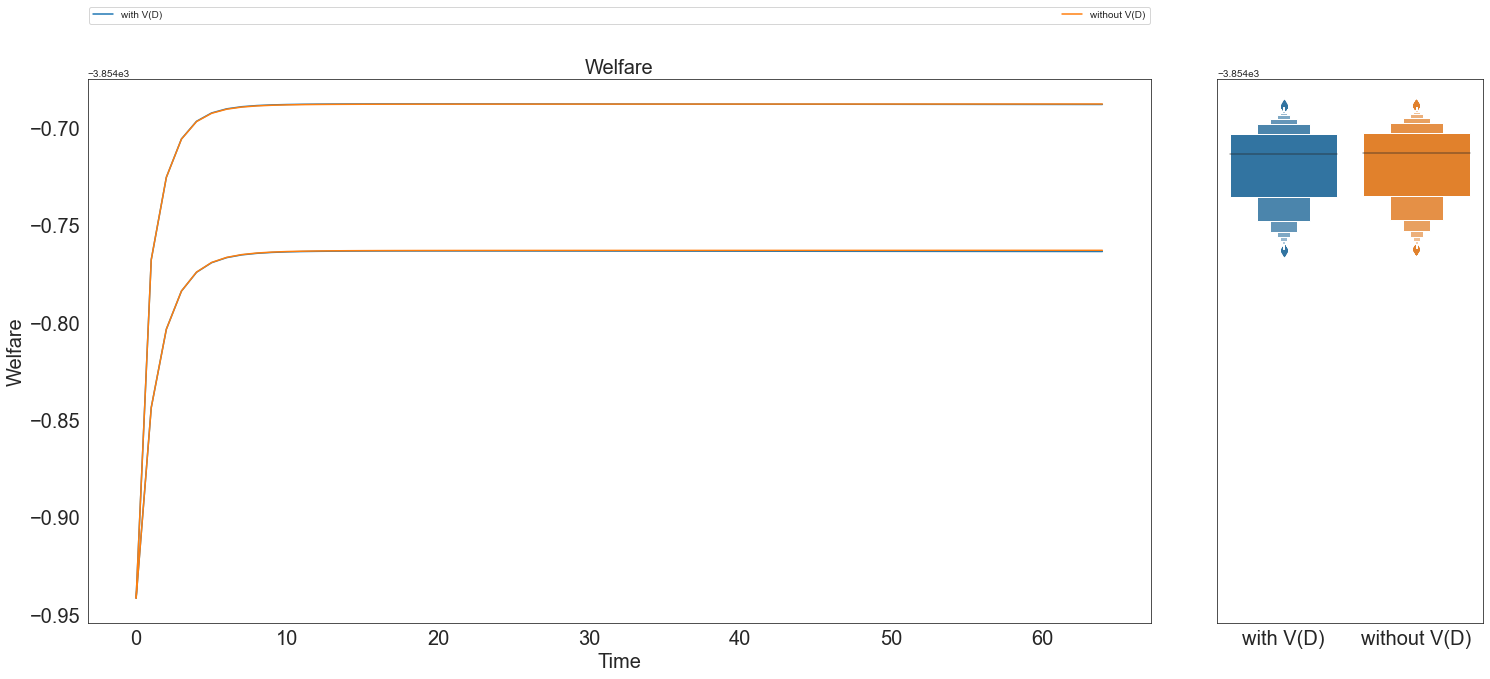

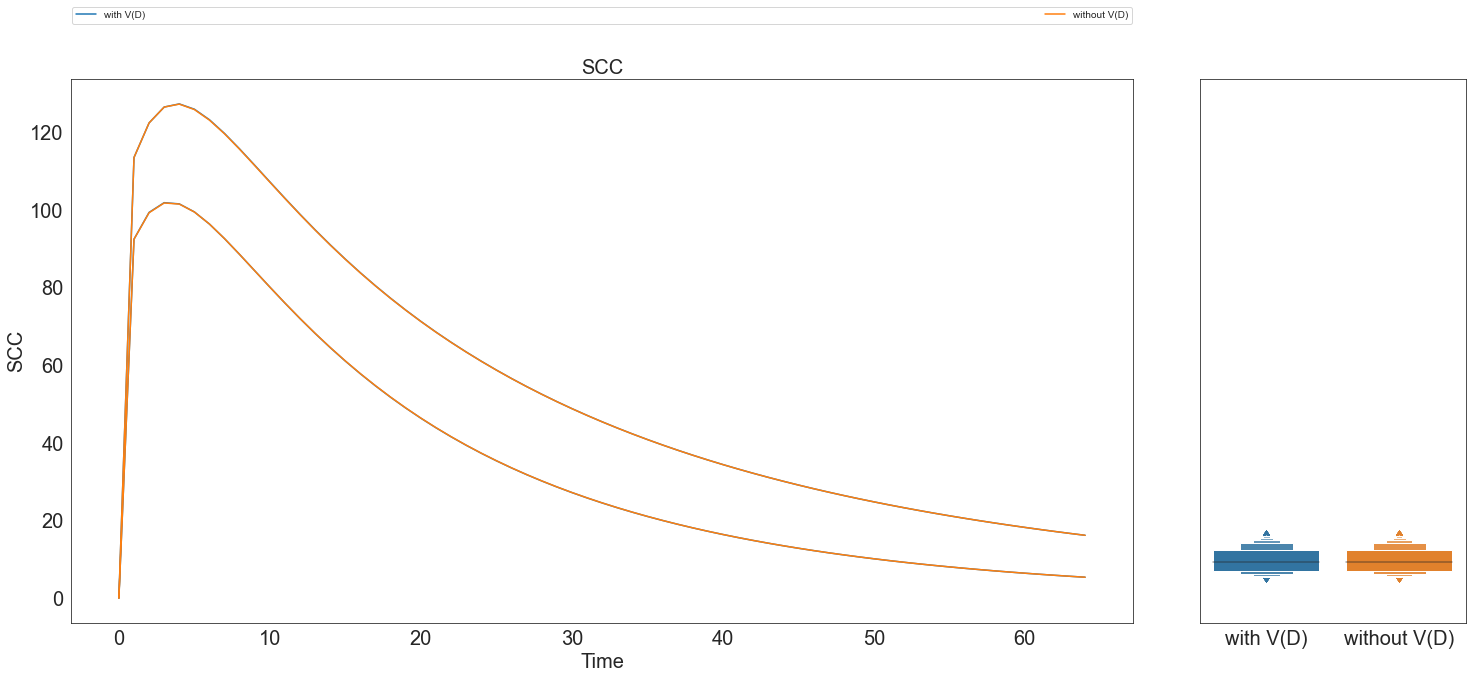

In [19]:
# Time series envelope outcome grouped by V(D) switch

for outcome in cleaned_outcome_pairs_time.keys():
    fig,axes=plotting.envelopes(experiments, cleaned_outcome_pairs_time, outcomes_to_show=outcome, density=plotting.Density.BOXENPLOT, group_by='vd_switch', grouping_specifiers= grouping_specifiers_VD,legend=True)
    

    fig.set_size_inches(25, 10)
    change_fontsize(fig, fs=20)
    repeat_token = 2
    fig.savefig(os.path.join(fig_path, str(run) +'_Time_grouped_envelope_' + str(outcome) + '_repeat' +str(repeat_token) + '.png'))
plt.show()


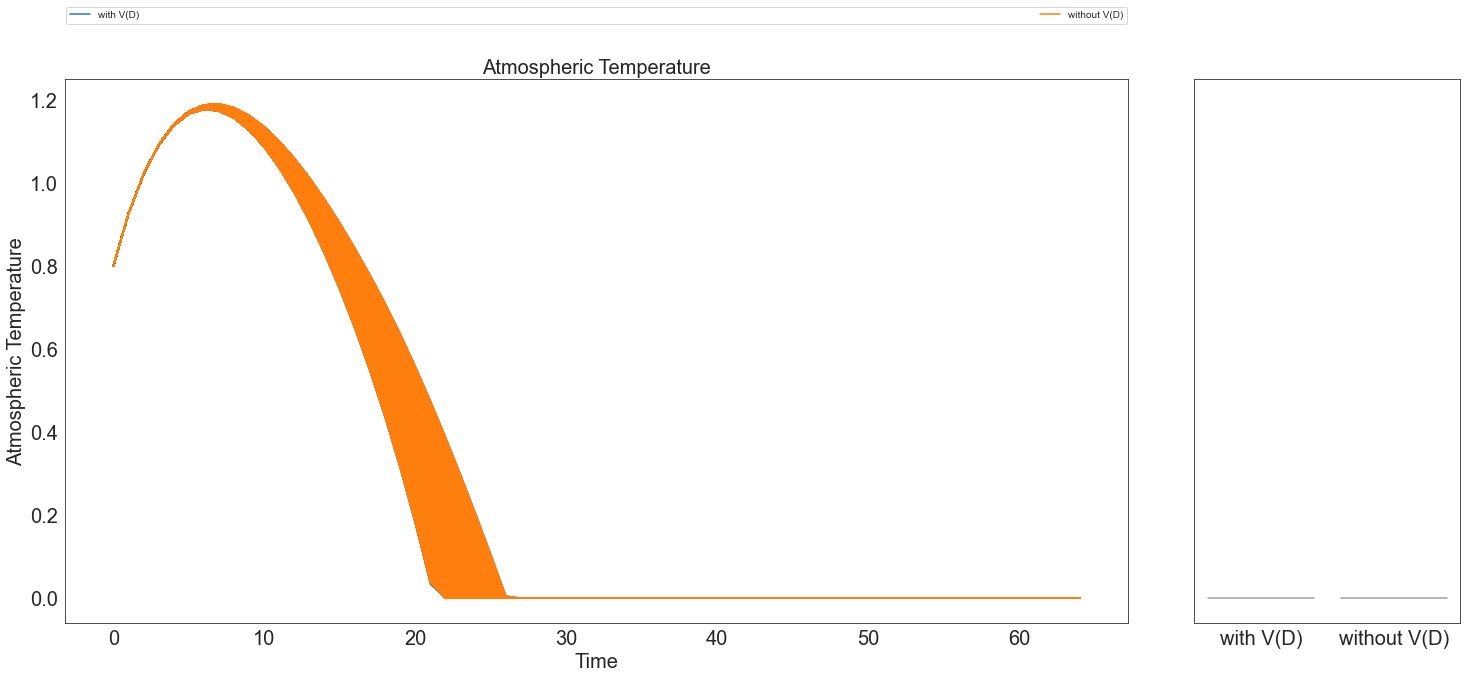

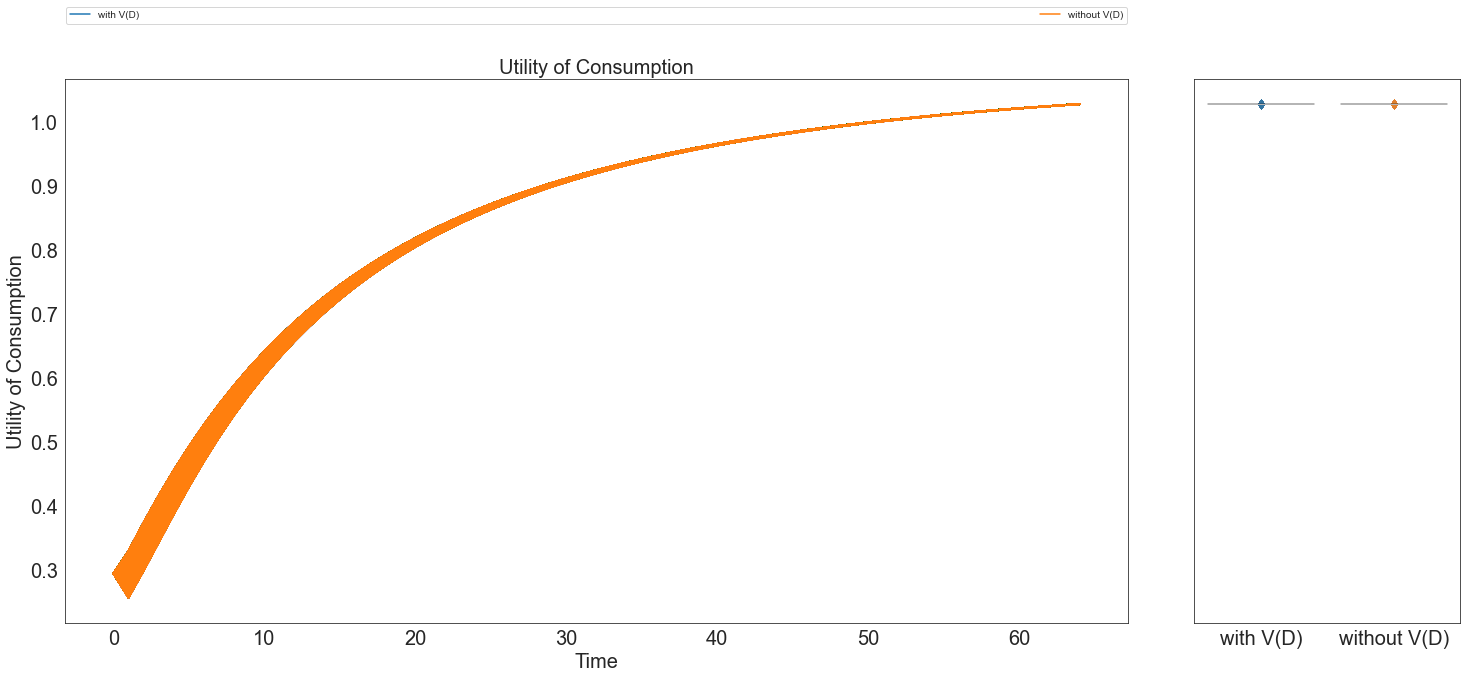

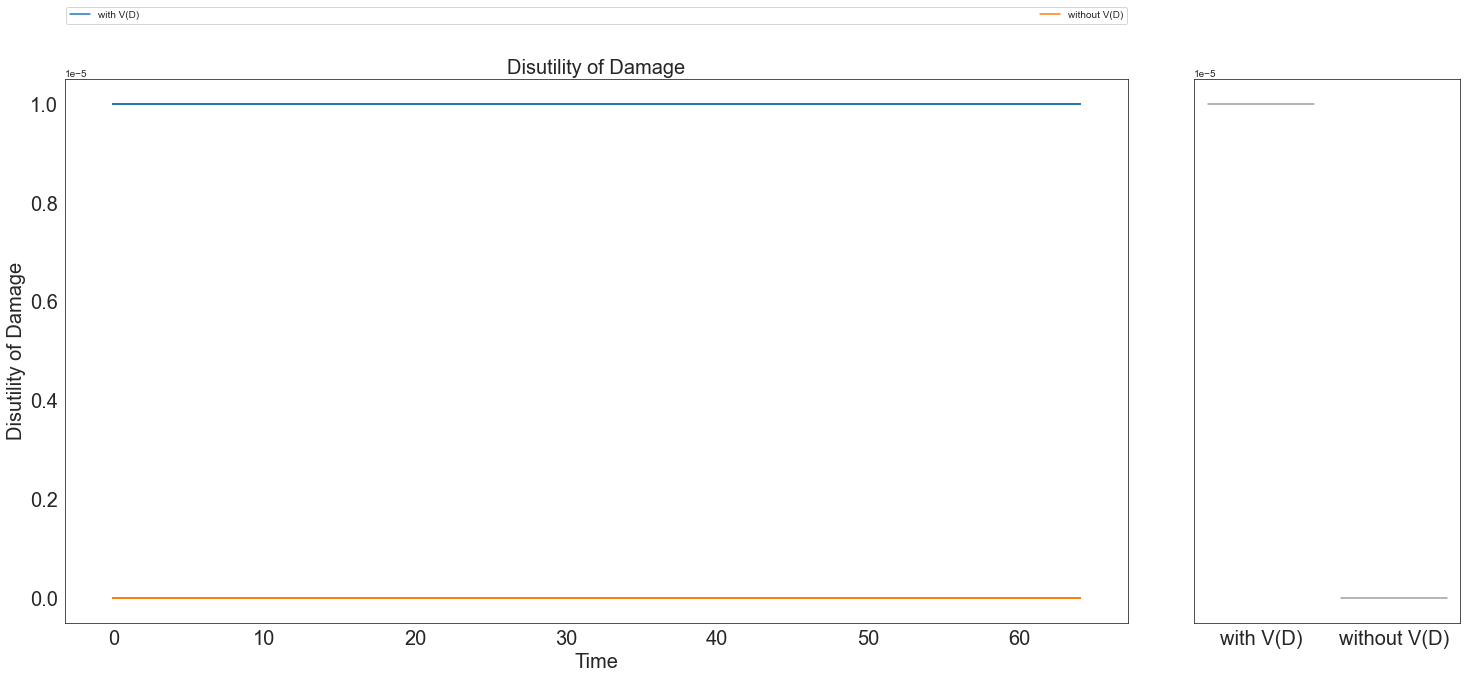

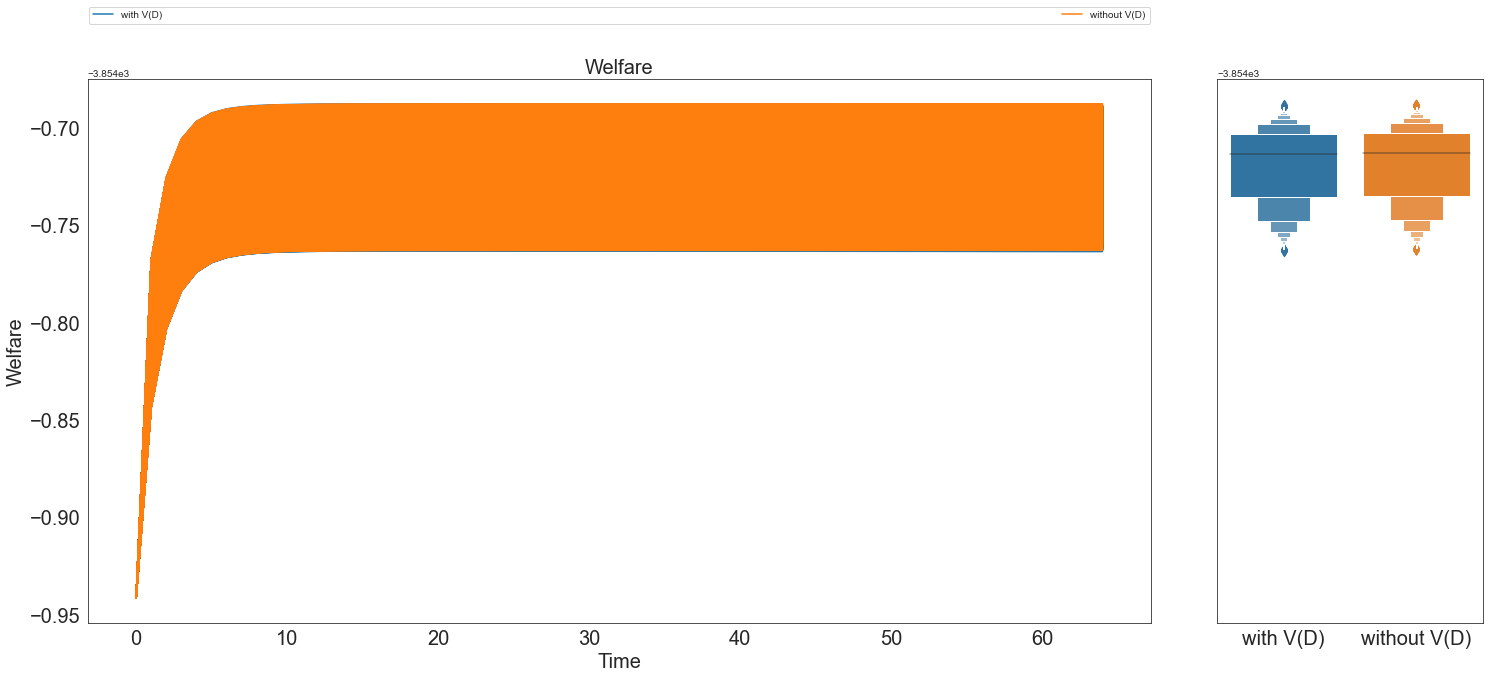

In [20]:
# Time series outcome grouped by V(D) switch

for outcome in cleaned_outcome_pairs_time.keys():
    fig,axes=plotting.lines(experiments, cleaned_outcome_pairs_time, outcomes_to_show=outcome, density=plotting.Density.BOXENPLOT, group_by='vd_switch', grouping_specifiers= grouping_specifiers_VD,legend=True)
    

    fig.set_size_inches(25, 10)
    change_fontsize(fig, fs=20)
    repeat_token = 1
    fig.savefig(os.path.join(fig_path, str(run) +'_Time_grouped_' + str(outcome) + '_repeat' +str(repeat_token) + '.png'))
plt.show()


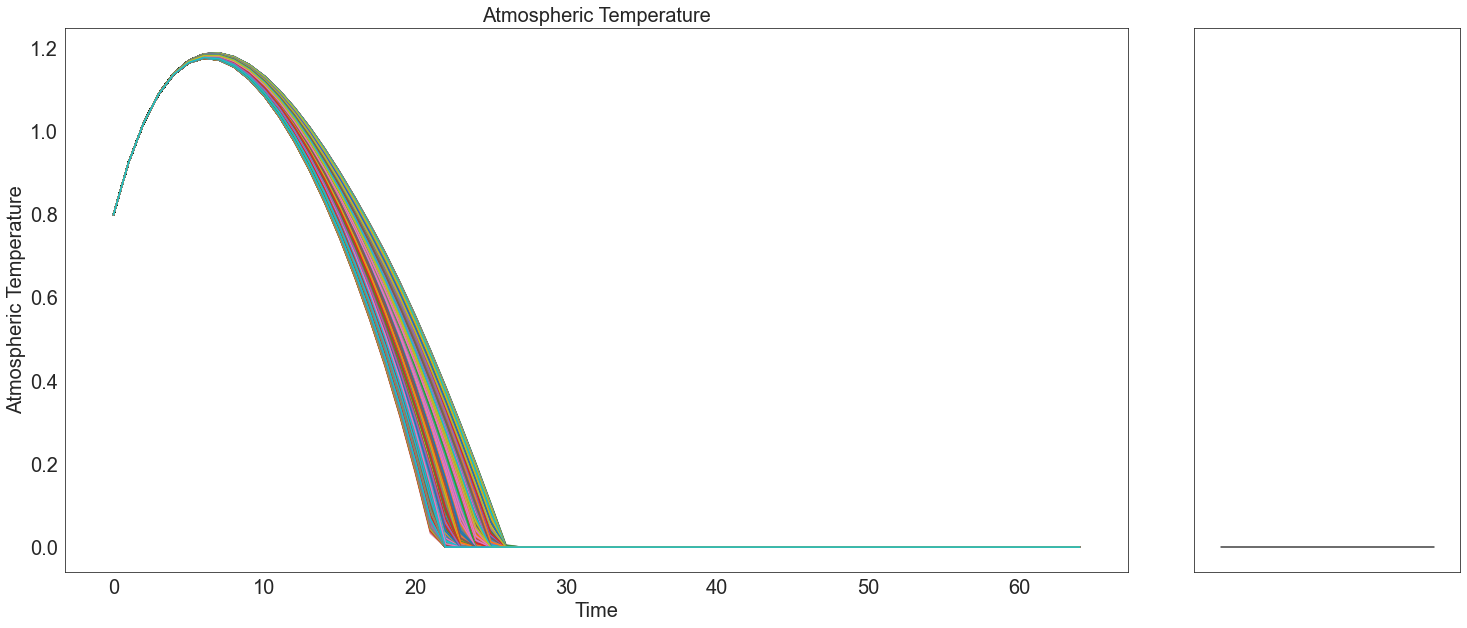

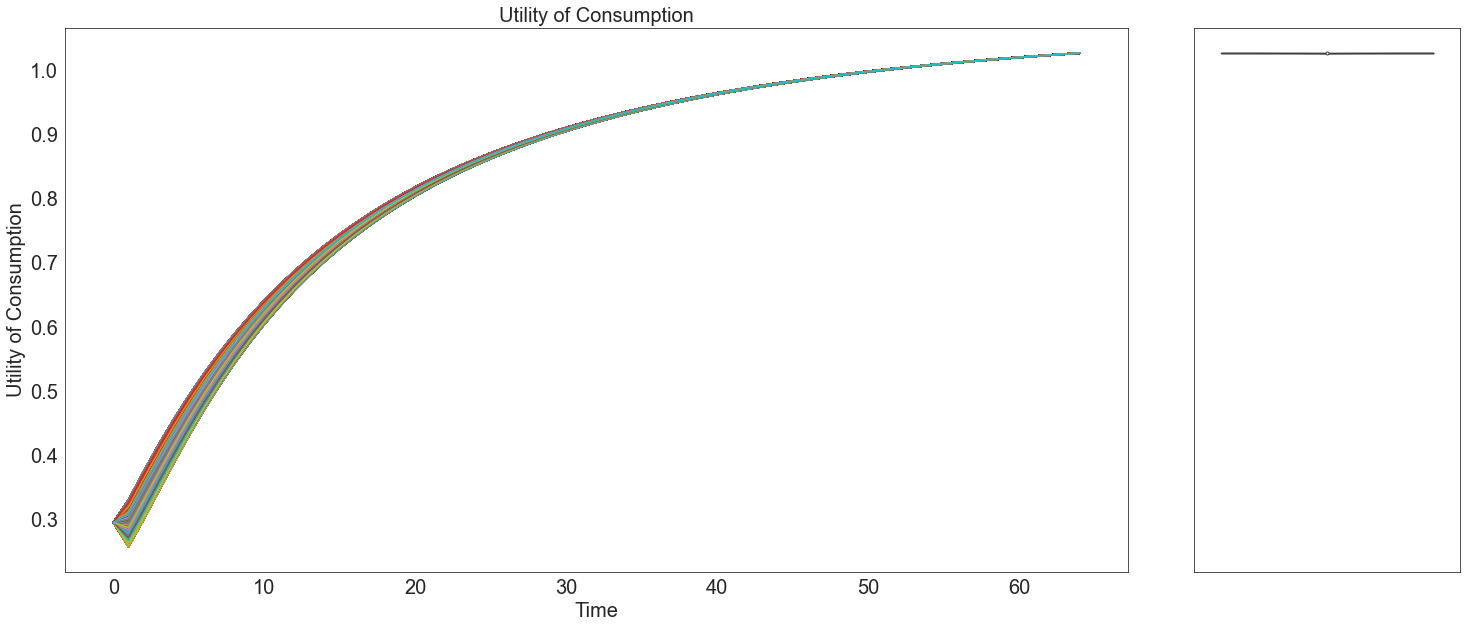

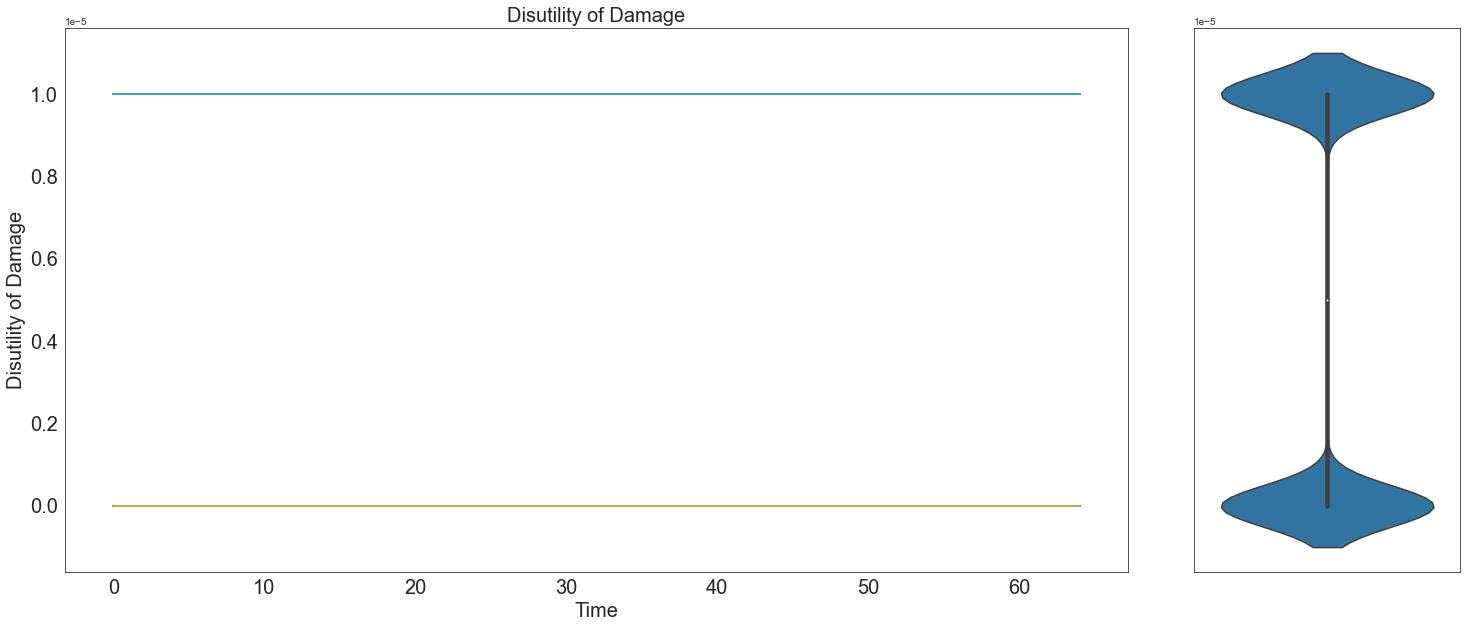

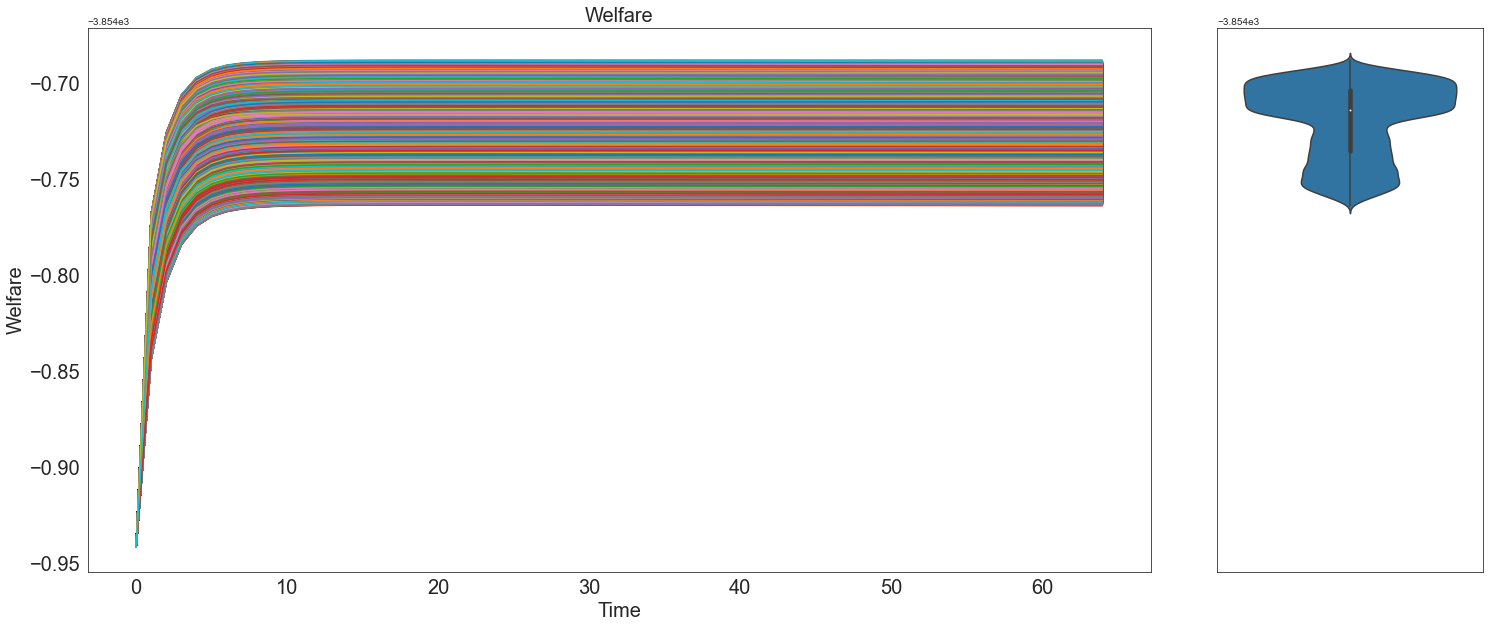

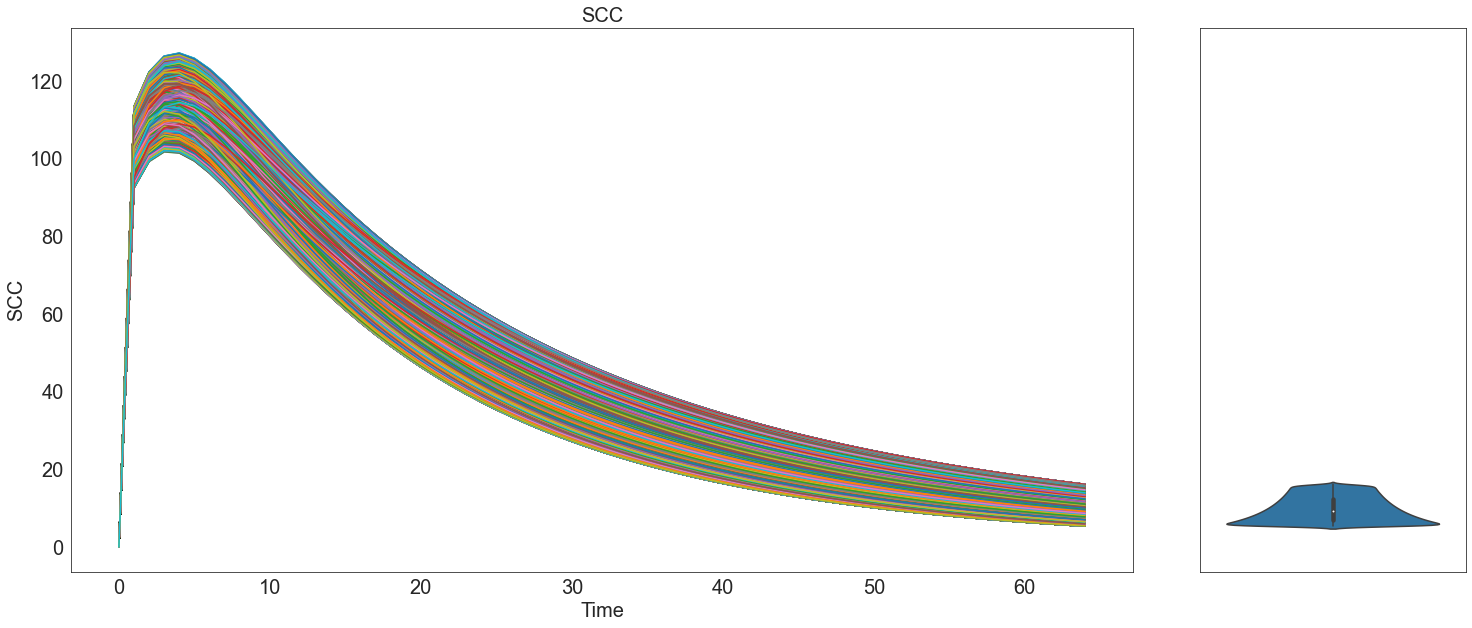

In [20]:
# Ungrouped Time series

for outcome in cleaned_outcome_pairs_time:
    fig,axes=plotting.lines(experiments, cleaned_outcome_pairs_time, 
    outcomes_to_show= outcome, density=plotting.Density.BOXENPLOT, legend=True)
    
    fig.set_size_inches(25,10)
    change_fontsize(fig, fs=20)
    fig.savefig(os.path.join(fig_path, str(run) + '_v7_TimeSeries_' + str(outcome) + '.png'))
plt.show()